In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
from utils import memoize, PriorityQueue
from search import UndirectedGraph, GraphProblem, Node
from matplotlib import lines
from matplotlib.colors import ListedColormap
from scipy.spatial import distance

## Modelagem do mapa

In [2]:
border = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
wall_right = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
wall_left = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
two_walls = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]

In [3]:
border = np.array(border)
wall_right = np.array(wall_right)
wall_left = np.array(wall_left)
two_walls = np.array(two_walls)


In [4]:
# Cria o board
board =[]

# Add parede de cima
board.append(border)

# Add 20 wall rights
board.extend([wall_right]*19)

# Add 20 wall duplas
board.extend([two_walls]*20)

# Add 20 wall lefts
board.extend([wall_left]*19)

# Add parede de baixo
board.append(border)

board = np.array(board)

print(board.shape)

(60, 60)


In [5]:
b = board.copy()
b[50][10] = 2
b[10][50] = 3

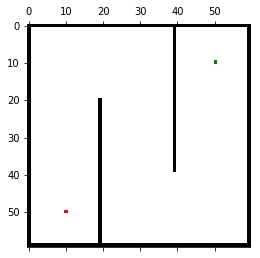

In [6]:
plt.matshow(b, cmap=ListedColormap(['k', 'w', 'r', 'g']))

# Grafo com vizinhos a 90 graus

In [7]:
state = {}
locations = {}
for i in range(60):
    for j in range(60):
        if board[i][j]:
            locations[60*i+j] = (i,j)
            # Cria nós com as vizinhanças
            neighbors = {}
            if i-1 < 60 and board[i-1][j]:
                neighbors[60*(i-1)+j] = 1
            if i+1 < 60 and board[i+1][j]:
                neighbors[60*(i+1)+j] = 1
            if j-1 < 60 and board[i][j-1]:
                neighbors[60*i+j-1] = 1
            if j+1 < 60 and board[i][j+1]:
                neighbors[60*i+j+1] = 1

            state[60*i+j] = neighbors 

In [8]:
node_colors = {node: 'white' for node in locations.keys()}
node_positions = locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in locations.items() }
edge_weights = {(k, k2) : v2 for k, v in state.items() for k2, v2 in v.items()}

robot_map = {  'graph_dict' : state,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

In [9]:
state = UndirectedGraph(state)
problem = GraphProblem(3010, 650, state)

## Funções auxiliares

In [10]:
def create_path(node):
    path = deque()
    n = node
    while n is not None:
        path.appendleft(n)
        n = n.parent
    return path

def print_path(path, explored):
    b = board.copy()    
    for node in explored:
        i, j = node_positions[node]
        b[i][j] = 3
    
    for node in path:
        i, j = node_positions[node.state]
        b[i][j] = 2
        
    plt.matshow(b, cmap=ListedColormap(['k','w','r','r','b']))

## Breadth First Search

A função foi copiada da biblioteca do AIMA com duas adaptações:
* Guardamos o caminho da solução encontrada
* Guardamos quantos nós foram visitados até a solução ser encontrada

In [11]:
def breadth_first_graph_search(problem):
    """[Figure 3.11]
    Note that this function can be implemented in a
    single line as below:
    return graph_search(problem, FIFOQueue())
    """
    node = Node(problem.initial)
    visitations = 0
    node.parent = None
    if problem.goal_test(node.state):
        return node, 0, explored
    frontier = deque([node])
    explored = set()
    while frontier:
        node = frontier.popleft()
        visitations += 1
        explored.add(node.state)
        for child in node.expand(problem):
            child.parent = node
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    return child, visitations, explored
                frontier.append(child)
    return None

Visitamos 3105 nós até encontrar um caminho-solução composto por 123 nós
CPU times: user 137 ms, sys: 120 µs, total: 138 ms
Wall time: 137 ms


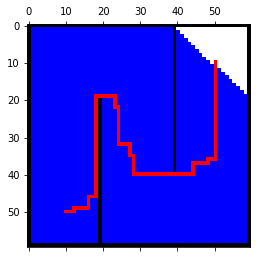

In [12]:
%%time
node, visitations, explored = breadth_first_graph_search(problem)
path = create_path(node)
print_path(path, explored)
print("Visitamos %d nós até encontrar um caminho-solução composto por %d nós" % (visitations, len(path)))

## Depth First Search

A função foi copiada da biblioteca do AIMA com duas adaptações:
* Guardamos o caminho da solução encontrada
* Guardamos quantos nós foram visitados até a solução ser encontrada

In [13]:
def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first.
        Search through the successors of a problem to find a goal.
        The argument frontier should be an empty queue.
        Does not get trapped by loops.
        If two paths reach a state, only use the first one. [Figure 3.7]"""
    initial_node = Node(problem.initial)
    initial_node.parent = None
    frontier = [(initial_node)]  # Stack
    visitations = 0
    explored = set()
    while frontier:
        node = frontier.pop()
        visitations += 1
        if problem.goal_test(node.state):
            return node, visitations, explored
        explored.add(node.state)
        for child in node.expand(problem):
            child.parent = node
            if child.state not in explored and child not in frontier:
                frontier.append(child)
    return None

Visitamos 1422 nós até encontrar um caminho-solução composto por 1111 nós
CPU times: user 1.28 s, sys: 2.03 ms, total: 1.28 s
Wall time: 1.28 s


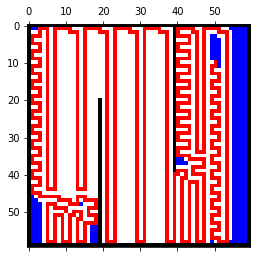

In [14]:
%%time
node, visitations, explored = depth_first_graph_search(problem)
path = create_path(node)
print_path(path, explored)
print("Visitamos %d nós até encontrar um caminho-solução composto por %d nós" % (visitations, len(path)))

## Best First Search

Utilizamos a função do A* da biblioteca do AIMA com a heurística f(n) = h(n) sendo h(n) a distância euclidiana para o nó meta

In [15]:
def f1(node):
    return distance.euclidean(node_positions[node.state], node_positions[3010])

In [16]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    f = memoize(f, 'f')
    node = Node(problem.initial)
    node.parent = None
    visitations = 0
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = set()
    while frontier:
        node = frontier.pop()
        visitations += 1
        if problem.goal_test(node.state):
            return node, visitations, explored
        explored.add(node.state)
        for child in node.expand(problem):
            child.parent = node
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
    return None

In [17]:
def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n))

Visitamos 3116 nós até encontrar um caminho-solução composto por 123 nós
CPU times: user 824 ms, sys: 24.8 ms, total: 848 ms
Wall time: 788 ms


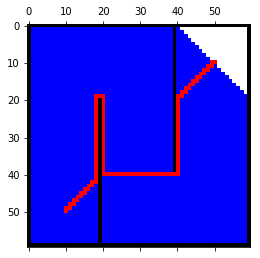

In [18]:
%%time
node, visitations, explored = astar_search(problem,f1)
path = create_path(node)
print_path(path, explored)
print("Visitamos %d nós até encontrar um caminho-solução composto por %d nós" % (visitations, len(path)))

## A* 

Aqui utilizamos uma heurística diferente

In [19]:
def f2(node):
    if node.parent is None:
        goal = Node(problem.initial)
    else:
        goal = node.parent.goal
    min_dist = 0x3f3f3f3f
    for child_goal in goal.expand(problem):
        for child in node.expand(problem):
            dist = distance.euclidean(node_positions[child.state], node_positions[child_goal.state])
            if dist < min_dist:
                min_dist = dist
                min_goal_child = child_goal
    
    node.goal = min_goal_child
    return min_dist

Visitamos 3125 nós até encontrar um caminho-solução composto por 123 nós
CPU times: user 3.87 s, sys: 0 ns, total: 3.87 s
Wall time: 3.91 s


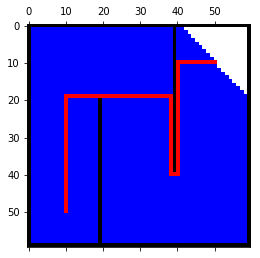

In [20]:
%%time
node, visitations, explored = astar_search(problem,f2)
path = create_path(node)
print_path(path, explored)
print("Visitamos %d nós até encontrar um caminho-solução composto por %d nós" % (visitations, len(path)))

## Discretizando com 45º

In [21]:
state = {}
locations = {}
for i in range(60):
    for j in range(60):
        if board[i][j]:
            locations[60*i+j] = (i,j)
            # Cria nós com as vizinhanças cima, baixo, esq, dir
            neighbors = {}
            if i-1 < 60 and board[i-1][j]:
                neighbors[60*(i-1)+j] = 1
            if i+1 < 60 and board[i+1][j]:
                neighbors[60*(i+1)+j] = 1
            if j-1 < 60 and board[i][j-1]:
                neighbors[60*i+j-1] = 1
            if j+1 < 60 and board[i][j+1]:
                neighbors[60*i+j+1] = 1
                
            # Cria nós com as vizinhanças em 45 graus
            if i-1 < 60 and j-1 < 60 and board[i-1][j-1]:
                neighbors[60*(i-1)+(j-1)] = 1
            if i-1 < 60 and j+1 < 60 and board[i-1][j+1]:
                neighbors[60*(i-1)+(j+1)] = 1
            if i+1 < 60 and j-1 < 60 and board[i+1][j-1]:
                neighbors[60*(i+1)+(j-1)] = 1
            if i+1 < 60 and j+1 < 60 and board[i+1][j+1]:
                neighbors[60*(i+1)+(j+1)] = 1
                
            state[60*i+j] = neighbors 

In [22]:
node_colors = {node: 'white' for node in locations.keys()}
node_positions = locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in locations.items() }
edge_weights = {(k, k2) : v2 for k, v in state.items() for k2, v2 in v.items()}

robot_map = {  'graph_dict' : state,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

In [23]:
state = UndirectedGraph(state)
problem = GraphProblem(3010, 650, state)

## Breadth First Search

Visitamos 3087 nós até encontrar um caminho-solução composto por 83 nós
CPU times: user 297 ms, sys: 3.69 ms, total: 300 ms
Wall time: 300 ms


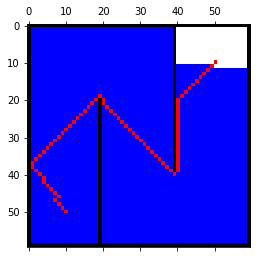

In [24]:
%%time
node, visitations, explored = breadth_first_graph_search(problem)
path = create_path(node)
print_path(path, explored)
print("Visitamos %d nós até encontrar um caminho-solução composto por %d nós" % (visitations, len(path)))

## Depth First Search

Visitamos 1546 nós até encontrar um caminho-solução composto por 394 nós
CPU times: user 2.02 s, sys: 72.6 ms, total: 2.09 s
Wall time: 2 s


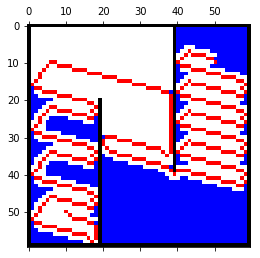

In [25]:
%%time
node, visitations, explored = depth_first_graph_search(problem)
path = create_path(node)
print_path(path, explored)
print("Visitamos %d nós até encontrar um caminho-solução composto por %d nós" % (visitations, len(path)))

## Best First Search

Visitamos 3110 nós até encontrar um caminho-solução composto por 83 nós
CPU times: user 2.05 s, sys: 55.6 ms, total: 2.1 s
Wall time: 1.99 s


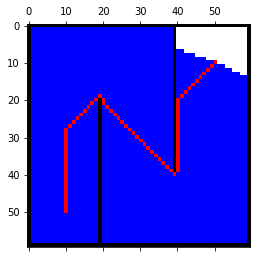

In [26]:
%%time
node, visitations, explored = astar_search(problem,f1)
path = create_path(node)
print_path(path, explored)
print("Visitamos %d nós até encontrar um caminho-solução composto por %d nós" % (visitations, len(path)))

## A* Search

Visitamos 3107 nós até encontrar um caminho-solução composto por 83 nós
CPU times: user 25.6 s, sys: 36.7 ms, total: 25.6 s
Wall time: 25.6 s


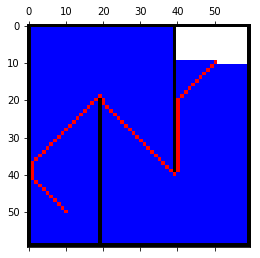

In [27]:
%%time
node, visitations, explored = astar_search(problem,f2)
path = create_path(node)
print_path(path, explored)
print("Visitamos %d nós até encontrar um caminho-solução composto por %d nós" % (visitations, len(path)))